In [1]:
%cd /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility

/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility


/software/cellgen/team361/aa34/envs/disect/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

# from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

from celldisect import CellDISECT
import rapids_singlecell as rsc
# from dis2p_reproducibility.dis2p_defunct import dis2pvi as dvi

import scib

from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

Global seed set to 0
Global seed set to 0


In [3]:
adata = sc.read_h5ad('../kang_normalized_hvg.h5ad')
adata = adata[adata.layers['counts'].sum(1) != 0].copy()

In [4]:
adata.layers['counts'].max()

3828.0

In [5]:
adata.X.max()

9.0423

In [6]:
from typing import NamedTuple

class _REGISTRY_KEYS_NT(NamedTuple):
    X_KEY: str = "X"
    BATCH_KEY: str = "batch"
    LABELS_KEY: str = "labels"
    PROTEIN_EXP_KEY: str = "proteins"
    CAT_COVS_KEY: str = "extra_categorical_covs"
    CONT_COVS_KEY: str = "extra_continuous_covs"
    INDICES_KEY: str = "ind_x"
    SIZE_FACTOR_KEY: str = "size_factor"
    LATENT_MODE_KEY: str = "latent_mode"
    LATENT_QZM_KEY: str = "latent_qzm"
    LATENT_QZV_KEY: str = "latent_qzv"


REGISTRY_KEYS = _REGISTRY_KEYS_NT()

In [7]:
cats = ['cell_type', 'condition']
cell_type_included = False # Set to True if you have provided a cell type annotation in the cats list
if not cell_type_included:
    adata.obs["_cluster"] = (
        "0"  # Dummy obs for inference (not-training) time, to avoid computing neighbors and clusters again in setup_anndata | AVOID ADDING BEFORE TRAINING
    )
pre_path = '../models/kang_ablation_celldisect_cfW_all1_focused01_tuned/'
model_paths = []
for model_path in os.listdir(pre_path):
    if 'CD14 Mono' in model_path:
        model_paths.append(model_path)

In [8]:
model_paths

['celldisect_allones_cfW_0.45_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.75_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.25_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.9_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.2_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.3_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.7_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.85_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.35_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.65_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.5_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.6_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.4_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.1_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.05_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.15_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.0_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.95_split_split_CD14 Mono',
 'celldisect_allones_cfW_1.0_split_sp

In [9]:
names = [name.split('_')[3] for name in model_paths]
names

['0.45',
 '0.75',
 '0.25',
 '0.9',
 '0.2',
 '0.3',
 '0.7',
 '0.85',
 '0.35',
 '0.65',
 '0.5',
 '0.6',
 '0.4',
 '0.1',
 '0.05',
 '0.15',
 '0.0',
 '0.95',
 '1.0',
 '0.8',
 '0.55']

In [10]:
models = {}
for i, model_path in enumerate(model_paths):
    models[names[i]] = CellDISECT.load(f"{pre_path}/{model_path}", adata=adata)

INFO     File                                                                                                      
         ../models/kang_ablation_celldisect_cfW_all1_focused01_tuned//celldisect_allones_cfW_0.45_split_split_CD14 
         Mono/model.pt already downloaded                                                                          


CUDA backend failed to initialize: Found CUDA version 12010, but JAX was built against version 12020, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     File                                                                                                      
         ../models/kang_ablation_celldisect_cfW_all1_focused01_tuned//celldisect_allones_cfW_0.75_split_split_CD14 
         Mono/model.pt already downloaded                                                                          
INFO     File                                                                                                      
         ../models/kang_ablation_celldisect_cfW_all1_focused01_tuned//celldisect_allones_cfW_0.25_split_split_CD14 
         Mono/model.pt already downloaded                                                                          
INFO     File                                                                                                      
         ../models/kang_ablation_celldisect_cfW_all1_focused01_tuned//celldisect_allones_cfW_0.9_split_split_CD14  
         Mono/model.pt already downloaded                               

In [11]:
models = dict(sorted(models.items(), key=lambda t: float(t[0])))

In [12]:
n_samples_from_source_max = 500

In [13]:
adata_ = adata[adata.obs['cell_type'] == 'CD14 Mono'].copy()
n_samples_from_source = min(n_samples_from_source_max, len(adata_[(adata_.obs['condition'] == 'ctrl')]))

cov_names = ['condition']
cov_values = ['ctrl']
cov_values_cf = ['stimulated']

In [14]:
adata.X = adata.layers['counts'].copy()
sc.pp.log1p(adata)
adata.obs['cov_condition'] = adata.obs['cell_type'].astype(str) + '_' + adata.obs.condition.astype(str)

groupby='cov_condition'
control_group='ctrl'
key_added="rank_genes_groups_pval0.05"
n_genes=200
return_dict=False
rankby_abs=True
gene_dict = {}
covariate = 'cell_type'
cov_categories = adata.obs[covariate].unique()
for cov_cat in cov_categories:
    print(cov_cat)
    # name of the control group in the groupby obs column
    control_group_cov = "_".join([cov_cat, control_group])
    adata_cov = adata[adata.obs[covariate] == cov_cat]

    sc.tl.rank_genes_groups(
        adata_cov,
        groupby=groupby,
        reference=control_group_cov,
        rankby_abs=rankby_abs,
        n_genes=n_genes,
        use_raw=False,
        method='wilcoxon',
    )

    de_genes_groups = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"]).columns

    de_genes = {}
    lfc = {}
    for group in de_genes_groups:
        # de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=None, log2fc_min=None, log2fc_max=None)['names']
        de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.05, log2fc_min=None, log2fc_max=None)['names']
        lfc[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.05, log2fc_min=None, log2fc_max=None)['logfoldchanges']

        lfc_indices = lfc[group].abs().sort_values(ascending=False).index
        de_genes[group] = de_genes[group][lfc_indices].reset_index(drop=True)

        gene_dict[group] = de_genes[group].tolist()

adata.uns[key_added] = gene_dict
adata.X = adata.layers['counts'].copy()

CD14 Mono
CD4 T
T
CD8 T
B
DC
CD16 Mono
NK


In [15]:
RANDOM_SEED = 42
preds = {}
for name, model in models.items():
    x_ctrl, x_true, x_pred = model.predict_counterfactuals(
                                            adata_.copy(),
                                            cov_names=cov_names,
                                            cov_values=cov_values,
                                            cov_values_cf=cov_values_cf,
                                            cats=cats,
                                            n_samples_from_source=n_samples_from_source,
                                            seed=RANDOM_SEED,
                                            )

    x_ctrl, x_true, x_pred = np.log1p(x_ctrl), np.log1p(x_true), np.log1p(x_pred)
    preds[name] = x_pred

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer set

In [16]:
deg_list = adata.uns[key_added]['CD14 Mono_stimulated']

In [17]:
from scipy.stats import wasserstein_distance

emd_results = {}
for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'
    emd_results[str(n_top_deg)] = {}
    for name, x_pred in preds.items():
        x_true_deg = x_true[:, degs]
        x_pred_deg = x_pred[:, degs]
        # for method_name, method in zip(['CellDISECT', 'Control'], [x_pred_deg, x_ctrl_deg]):
        wd = []
        for i in range(x_true_deg.shape[1]):
            wd.append(
                wasserstein_distance(torch.tensor(x_true_deg[:, i]), torch.tensor(x_pred_deg[:, i]))
            )
        emd_results[str(n_top_deg)][name] = np.mean(wd)

emd_results = pd.DataFrame.from_dict(emd_results).T
emd_results

0.0      0.05       0.1      0.15       0.2      0.25       0.3  \
20   0.753674  0.749523  0.758474  0.741875  0.721958  0.719218  0.738754   
all  0.072460  0.077093  0.074180  0.078702  0.078127  0.078975  0.077825   

         0.35       0.4      0.45  ...      0.55       0.6      0.65  \
20   0.714025  0.742980  0.739811  ...  0.752498  0.757503  0.756974   
all  0.090283  0.086246  0.085346  ...  0.097098  0.096374  0.095418   

          0.7      0.75       0.8      0.85       0.9      0.95       1.0  
20   0.759642  0.760203  0.760970  0.763223  0.767702  0.770851  0.770896  
all  0.094953  0.094960  0.093932  0.093293  0.093153  0.092803  0.092553  

[2 rows x 21 columns]

In [18]:
r2_results = {}
for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'
    r2_results[str(n_top_deg)] = {}
    for name, x_pred in preds.items():
        
        x_true_deg = x_true[:, degs]
        x_pred_deg = x_pred[:, degs]

        r2_mean_deg = pearsonr(x_true_deg.mean(0), x_pred_deg.mean(0))

        r2_var_deg = pearsonr(x_true_deg.var(0), x_pred_deg.var(0))

        r2_results[str(n_top_deg)][name] = r2_mean_deg[0]

        r2_results[str(n_top_deg)][name+'_var'] = r2_var_deg[0]

r2_results = pd.DataFrame.from_dict(r2_results).T
r2_results

0.0   0.0_var      0.05  0.05_var       0.1   0.1_var      0.15  \
20   0.956499  0.559539  0.955124  0.567456  0.955811  0.564385  0.954161   
all  0.939810  0.788096  0.935853  0.791549  0.936693  0.782206  0.933420   

     0.15_var       0.2   0.2_var  ...       0.8   0.8_var      0.85  \
20   0.545670  0.955427  0.582774  ...  0.934942  0.453259  0.934761   
all  0.786301  0.937428  0.798353  ...  0.925600  0.740469  0.925896   

     0.85_var       0.9   0.9_var      0.95  0.95_var       1.0   1.0_var  
20   0.448723  0.934343  0.447462  0.934176  0.458186  0.934148  0.439967  
all  0.741409  0.926268  0.738403  0.926234  0.741854  0.926668  0.739767  

[2 rows x 42 columns]

In [19]:
r2_results_subtract = {}
for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'
    r2_results_subtract[str(n_top_deg)] = {}
    for name, x_pred in preds.items():

        x_true_deg = x_true[:, degs]
        x_pred_deg = x_pred[:, degs]
        x_ctrl_deg = x_ctrl[:, degs]


        r2_mean_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))

        r2_var_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))

        r2_results_subtract[str(n_top_deg)][name] = r2_mean_deg[0]

        r2_results_subtract[str(n_top_deg)][name+'_var'] = r2_var_deg[0]

r2_results_subtract = pd.DataFrame.from_dict(r2_results_subtract).T
r2_results_subtract

0.0   0.0_var     0.05  0.05_var       0.1   0.1_var      0.15  \
20   0.953341  0.500124  0.95167  0.528032  0.952514  0.508852  0.950554   
all  0.854541  0.188733  0.84382  0.194344  0.846474  0.186780  0.836023   

     0.15_var       0.2   0.2_var  ...       0.8   0.8_var      0.85  \
20   0.500528  0.951741  0.549595  ...  0.928191  0.434819  0.928013   
all  0.188312  0.847415  0.197992  ...  0.817166  0.167828  0.817982   

     0.85_var       0.9   0.9_var      0.95  0.95_var       1.0   1.0_var  
20   0.421511  0.927647  0.412065  0.927465  0.423672  0.927342  0.417558  
all  0.164889  0.819108  0.163180  0.819101  0.164367  0.820313  0.162291  

[2 rows x 42 columns]

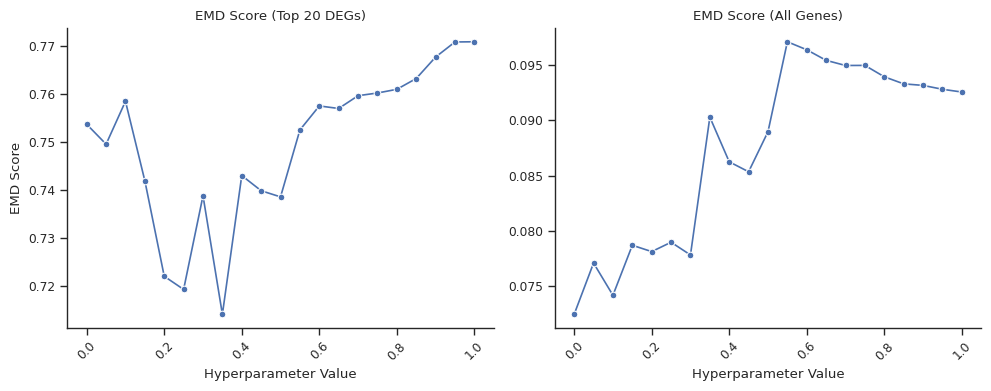

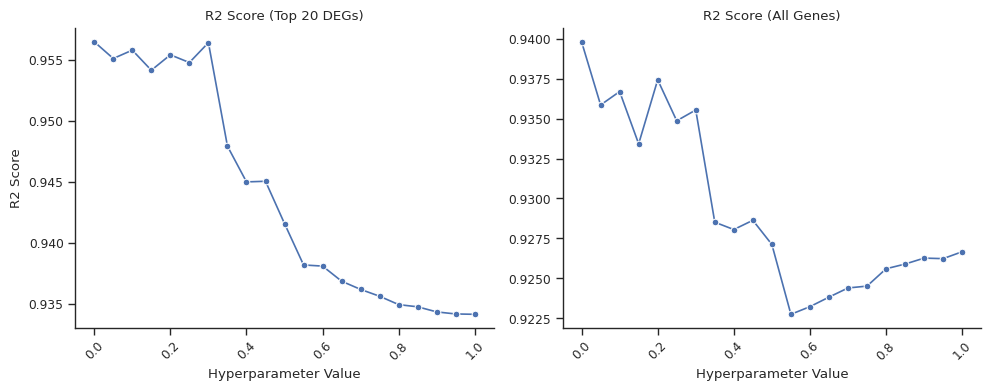

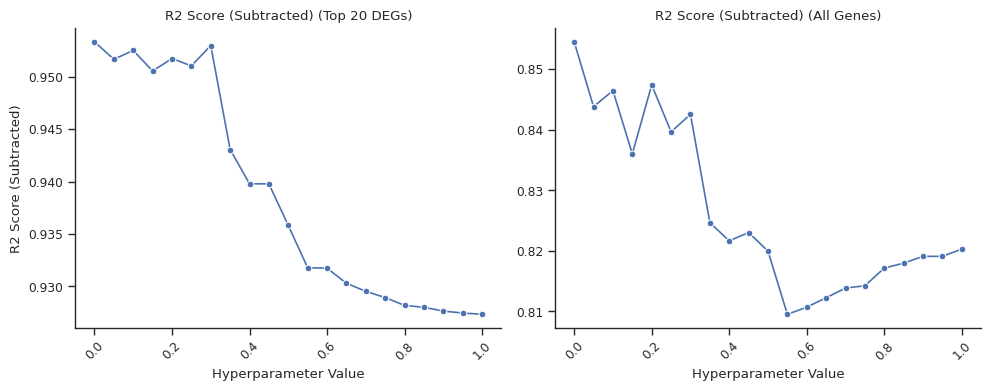

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # Import regex module for parsing column names

# --- Assuming your dataframes emd_results, r2_results, r2_results_subtract are already populated ---
# Example DataFrames (replace with your actual data)
# emd_results = pd.DataFrame(...)
# r2_results = pd.DataFrame(...)
# r2_results_subtract = pd.DataFrame(...)

# Set a professional plot style
sns.set_theme(style="ticks", context="paper") # 'paper' context for publication quality font sizes

def plot_ablation_metric(df, metric_name, filename_base):
    """
    Generates and saves a two-panel plot for an ablation study metric.

    Args:
        df (pd.DataFrame): DataFrame containing the metric results.
                           Rows should be '20' and 'all'.
                           Columns should be hyperparameter values (numeric strings).
        metric_name (str): The name of the metric (e.g., 'EMD', 'R2 Score').
        filename_base (str): Base name for the saved plot file.
    """
    # Filter out variance columns and sort by hyperparameter value
    metric_cols = [col for col in df.columns if '_var' not in col]
    
    # Extract hyperparameter values and convert to numeric
    try:
        hyperparams = sorted([float(re.match(r"([0-9.]+)", col).group(1)) for col in metric_cols])
        # Ensure columns in the DataFrame match the sorted hyperparams
        sorted_metric_cols = [col for hp in hyperparams for col in metric_cols if f"{hp}" == re.match(r"([0-9.]+)", col).group(1)]
        
        df_filtered = df[sorted_metric_cols]
        df_filtered.columns = hyperparams # Rename columns to numeric hyperparams for plotting
        
    except (ValueError, AttributeError) as e:
        print(f"Error processing column names for {metric_name}: {e}")
        print("Please ensure column names represent numeric hyperparameter values.")
        return

    if '20' not in df_filtered.index or 'all' not in df_filtered.index:
        print(f"Error: DataFrame for {metric_name} missing '20' or 'all' index.")
        return
        
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False) # Adjust figsize as needed

    # Plot for Top 20 DEGs
    sns.lineplot(x=df_filtered.columns, y=df_filtered.loc['20'], marker='o', ax=axes[0], errorbar=None)
    axes[0].set_title(f'{metric_name} (Top 20 DEGs)')
    axes[0].set_xlabel('Hyperparameter Value')
    axes[0].set_ylabel(metric_name)
    axes[0].tick_params(axis='x', rotation=45)

    # Plot for All Genes
    sns.lineplot(x=df_filtered.columns, y=df_filtered.loc['all'], marker='o', ax=axes[1], errorbar=None)
    axes[1].set_title(f'{metric_name} (All Genes)')
    axes[1].set_xlabel('Hyperparameter Value')
    axes[1].set_ylabel('') # Hide y-label to avoid redundancy if scales are similar, or set explicitly
    axes[1].tick_params(axis='x', rotation=45)

    # Improve layout and save
    sns.despine(fig=fig)
    plt.tight_layout()
    plt.savefig(f'{filename_base}.png', dpi=300) # Save as PNG with high resolution
    plt.savefig(f'{filename_base}.pdf')      # Save as PDF for vector quality
    plt.show()

# --- Generate the plots ---

# Make sure your DataFrames (emd_results, r2_results, r2_results_subtract) exist before running this
if 'emd_results' in locals():
    plot_ablation_metric(emd_results, 'EMD Score', 'ablation_emd')
else:
    print("emd_results DataFrame not found.")

if 'r2_results' in locals():
    plot_ablation_metric(r2_results, 'R2 Score', 'ablation_r2')
else:
    print("r2_results DataFrame not found.")

if 'r2_results_subtract' in locals():
    plot_ablation_metric(r2_results_subtract, 'R2 Score (Subtracted)', 'ablation_r2_subtracted')
else:
    print("r2_results_subtract DataFrame not found.")


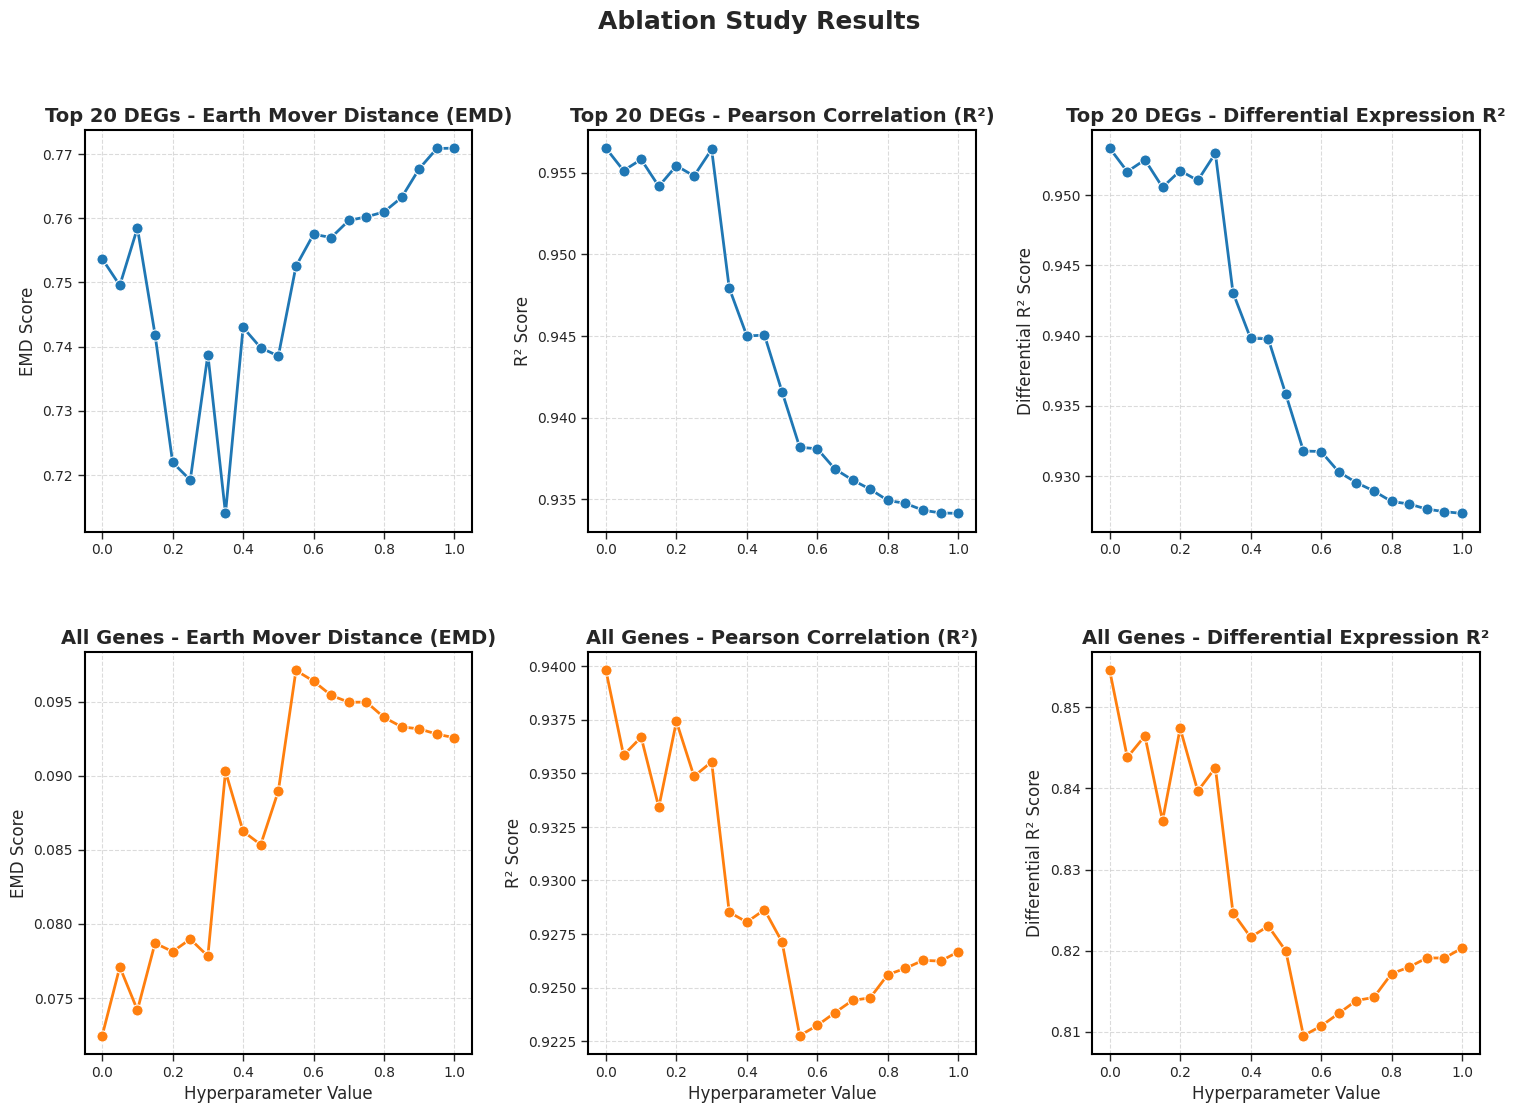

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

# Set publication-ready style
# plt.style.use('seaborn-whitegrid')
sns.set_context("paper", font_scale=1.5)
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'

# Function to prepare data and filter out variance columns
def prepare_data(df):
    # Convert column labels to float for proper ordering
    df_processed = df.copy()
    # Filter out variance columns
    cols_to_keep = [col for col in df_processed.columns if '_var' not in col]
    df_processed = df_processed[cols_to_keep]
    # Convert column names to float for sorting
    df_processed.columns = [float(col) for col in df_processed.columns]
    # Sort columns
    df_processed = df_processed.reindex(columns=sorted(df_processed.columns))
    return df_processed

# Create figure for each metric
def plot_ablation_results(metric_df, metric_name, ylabel):
    df = prepare_data(metric_df)
    
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 1, height_ratios=[1, 1], hspace=0.3)
    
    # Plot for top 20 DEGs
    ax1 = fig.add_subplot(gs[0])
    if '20' in df.index:
        data_20 = df.loc['20'].reset_index()
        data_20.columns = ['Hyperparameter', 'Score']
        sns.lineplot(x='Hyperparameter', y='Score', data=data_20, 
                   marker='o', markersize=8, linewidth=2, color='#1f77b4', ax=ax1)
        ax1.set_title('Top 20 DEGs', fontsize=16, fontweight='bold')
        ax1.set_xlabel('')
        ax1.set_ylabel(ylabel, fontsize=14)
        ax1.tick_params(axis='both', which='major', labelsize=12)
    
    # Plot for all genes
    ax2 = fig.add_subplot(gs[1])
    if 'all' in df.index:
        data_all = df.loc['all'].reset_index()
        data_all.columns = ['Hyperparameter', 'Score']
        sns.lineplot(x='Hyperparameter', y='Score', data=data_all, 
                   marker='o', markersize=8, linewidth=2, color='#ff7f0e', ax=ax2)
        ax2.set_title('All Genes', fontsize=16, fontweight='bold')
        ax2.set_xlabel('Hyperparameter Value', fontsize=14)
        ax2.set_ylabel(ylabel, fontsize=14)
        ax2.tick_params(axis='both', which='major', labelsize=12)
    
    plt.suptitle(f'{metric_name} Ablation Study', fontsize=18, fontweight='bold', y=0.98)
    
    # Ensure all x-axes have the same limits for consistency
    x_min = min(df.columns)
    x_max = max(df.columns)
    ax1.set_xlim(x_min - 0.05, x_max + 0.05)
    ax2.set_xlim(x_min - 0.05, x_max + 0.05)
    
    # Add grid for better readability
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    return fig

# Create combined figure with all metrics
def plot_combined_metrics(emd_df, r2_df, r2_subtract_df):
    metrics = [
        (prepare_data(emd_df), 'Earth Mover Distance (EMD)', 'EMD Score'),
        (prepare_data(r2_df), 'Pearson Correlation (R²)', 'R² Score'),
        (prepare_data(r2_subtract_df), 'Differential Expression R²', 'Differential R² Score')
    ]
    
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(2, 3, height_ratios=[1, 1], hspace=0.3, wspace=0.3)
    
    for i, (df, title, ylabel) in enumerate(metrics):
        # Plot for top 20 DEGs
        ax1 = fig.add_subplot(gs[0, i])
        if '20' in df.index:
            data_20 = df.loc['20'].reset_index()
            data_20.columns = ['Hyperparameter', 'Score']
            sns.lineplot(x='Hyperparameter', y='Score', data=data_20, 
                       marker='o', markersize=8, linewidth=2, color='#1f77b4', ax=ax1)
            ax1.set_title(f'Top 20 DEGs - {title}', fontsize=14, fontweight='bold')
            ax1.set_xlabel('')
            ax1.set_ylabel(ylabel, fontsize=12)
            ax1.tick_params(axis='both', which='major', labelsize=10)
        
        # Plot for all genes
        ax2 = fig.add_subplot(gs[1, i])
        if 'all' in df.index:
            data_all = df.loc['all'].reset_index()
            data_all.columns = ['Hyperparameter', 'Score']
            sns.lineplot(x='Hyperparameter', y='Score', data=data_all, 
                       marker='o', markersize=8, linewidth=2, color='#ff7f0e', ax=ax2)
            ax2.set_title(f'All Genes - {title}', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Hyperparameter Value', fontsize=12)
            ax2.set_ylabel(ylabel, fontsize=12)
            ax2.tick_params(axis='both', which='major', labelsize=10)
        
        # Add grid for better readability
        ax1.grid(True, linestyle='--', alpha=0.7)
        ax2.grid(True, linestyle='--', alpha=0.7)
        
        # Ensure x-axes have the same limits within each metric
        x_min = min(df.columns)
        x_max = max(df.columns)
        ax1.set_xlim(x_min - 0.05, x_max + 0.05)
        ax2.set_xlim(x_min - 0.05, x_max + 0.05)
    
    plt.suptitle('Ablation Study Results', fontsize=18, fontweight='bold', y=0.98)
    
    return fig

# # Generate individual plots
# emd_fig = plot_ablation_results(emd_results, 'Earth Mover Distance (EMD)', 'EMD Score')
# r2_fig = plot_ablation_results(r2_results, 'Pearson Correlation (R²)', 'R² Score')
# r2_subtract_fig = plot_ablation_results(r2_results_subtract, 'Differential Expression R²', 'Differential R² Score')

# Generate combined plot
combined_fig = plot_combined_metrics(emd_results, r2_results, r2_results_subtract)

# Save figures with high resolution
# emd_fig.savefig('emd_ablation.pdf', dpi=300, bbox_inches='tight')
# r2_fig.savefig('r2_ablation.pdf', dpi=300, bbox_inches='tight')
# r2_subtract_fig.savefig('r2_subtract_ablation.pdf', dpi=300, bbox_inches='tight')
combined_fig.savefig('combined_ablation.pdf', dpi=300, bbox_inches='tight')

# Show figures
plt.show()

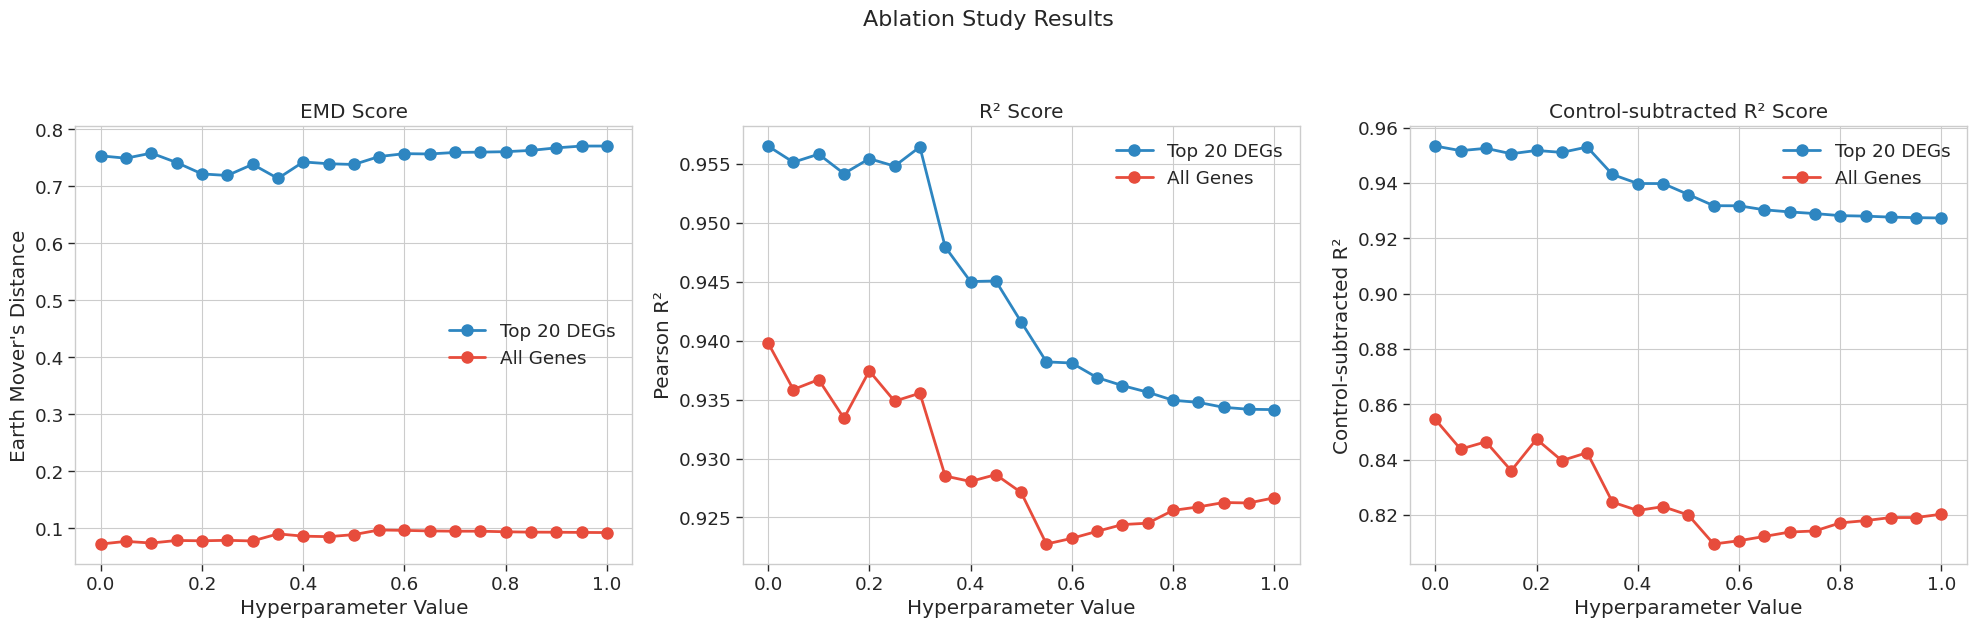

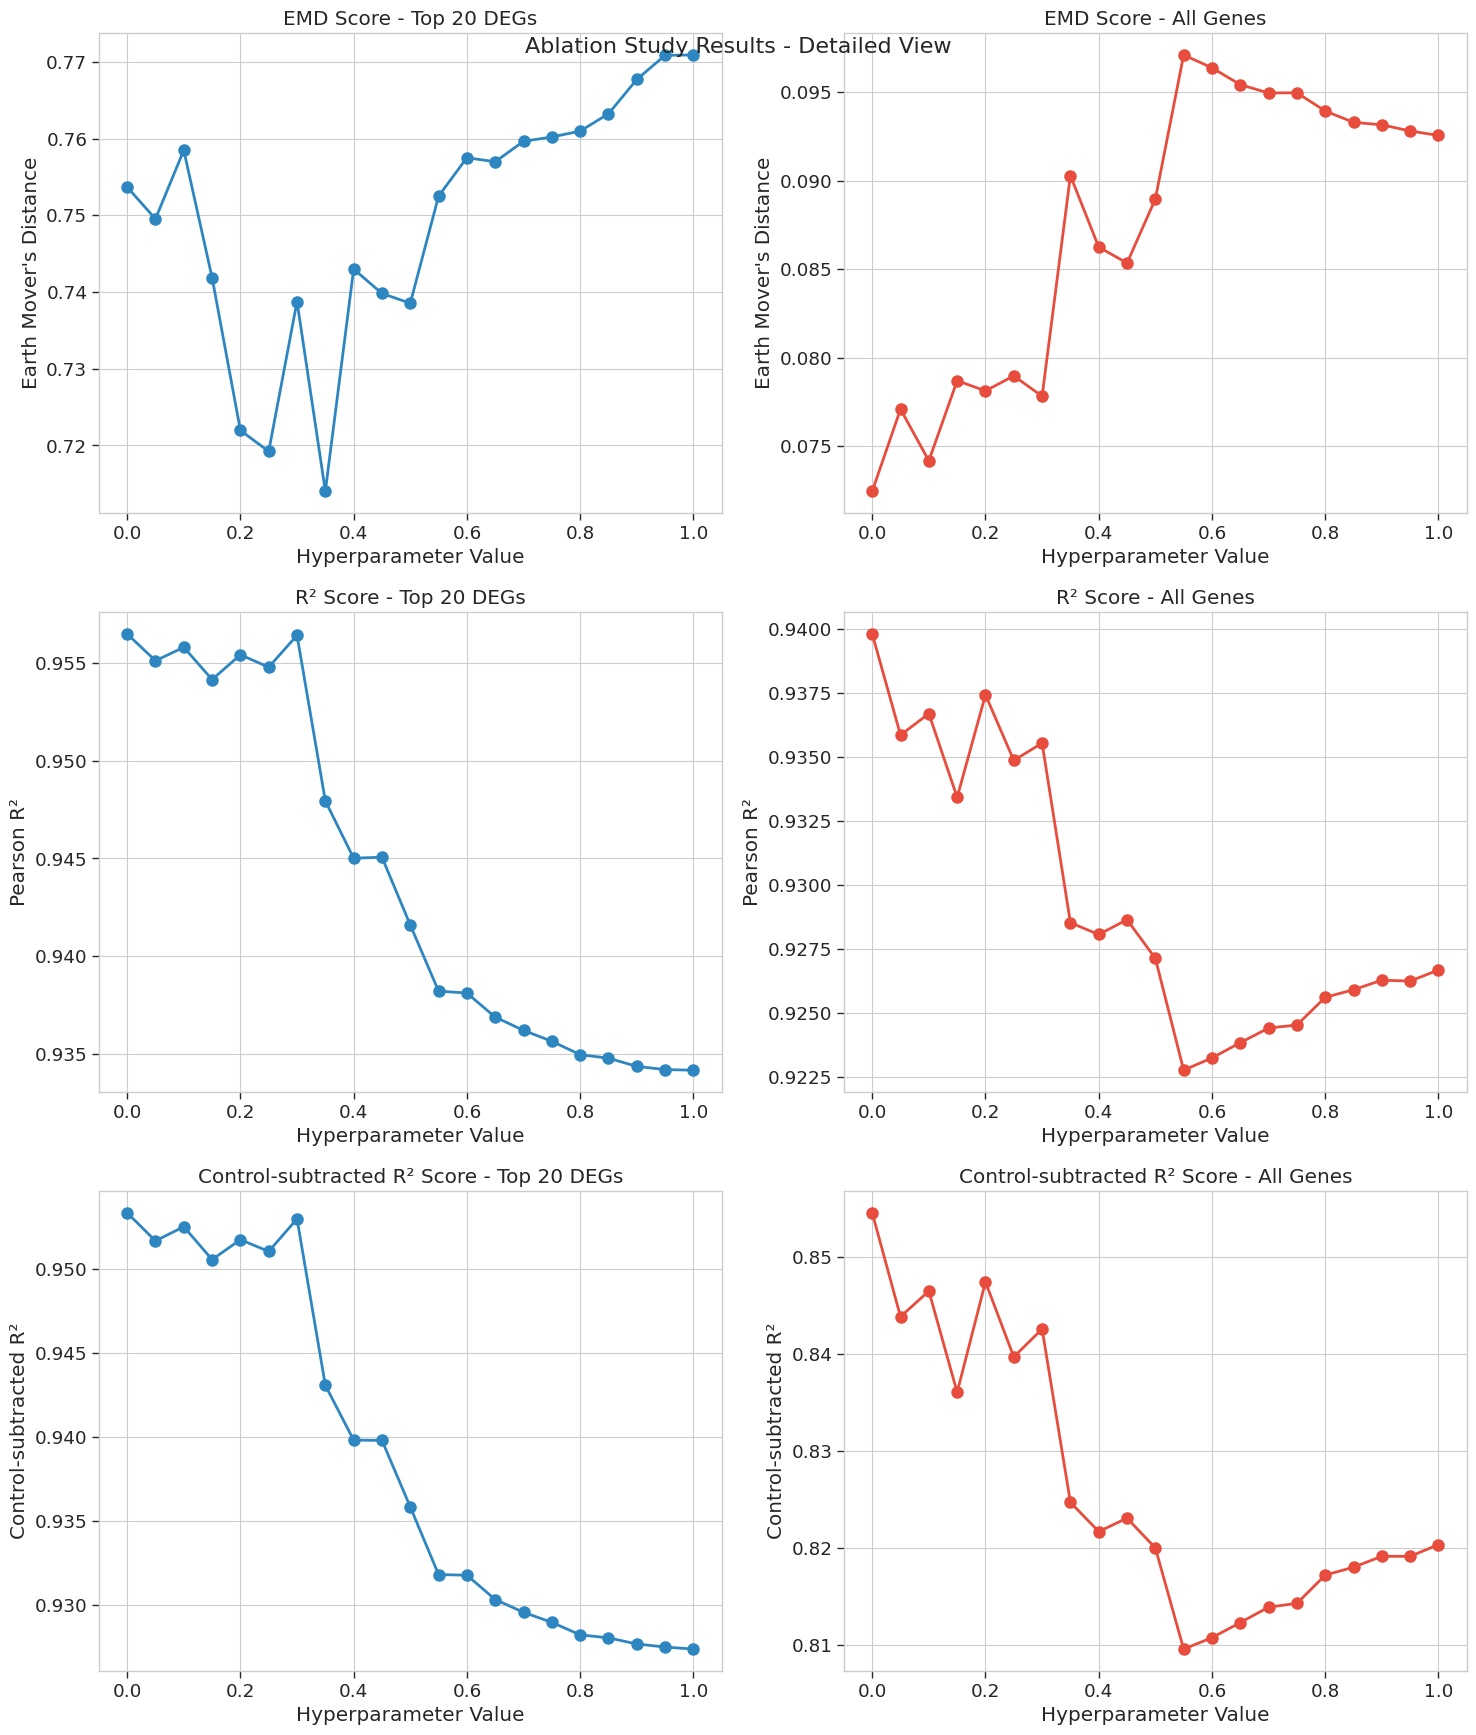

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set the style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.5)

# Create figure with subplots - one row, three columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Ablation Study Results', fontsize=16, y=1.05)

# Colors for consistency
colors = {'20': '#2E86C1', 'all': '#E74C3C'}

# Helper function to prepare data for plotting
def prepare_data(df):
    # Get hyperparameter values (columns without '_var')
    hyper_values = [float(col) for col in df.columns if '_var' not in col]
    
    data_20 = [df.loc['20', str(val)] for val in hyper_values]
    data_all = [df.loc['all', str(val)] for val in hyper_values]
    
    return hyper_values, data_20, data_all

# Plot EMD Results
hyper_values, emd_20, emd_all = prepare_data(emd_results)

ax1.plot(hyper_values, emd_20, 'o-', color=colors['20'], label='Top 20 DEGs', linewidth=2, markersize=8)
ax1.plot(hyper_values, emd_all, 'o-', color=colors['all'], label='All Genes', linewidth=2, markersize=8)
ax1.set_xlabel('Hyperparameter Value')
ax1.set_ylabel('Earth Mover\'s Distance')
ax1.set_title('EMD Score')
ax1.legend()

# Plot R2 Results
hyper_values, r2_20, r2_all = prepare_data(r2_results)

ax2.plot(hyper_values, r2_20, 'o-', color=colors['20'], label='Top 20 DEGs', linewidth=2, markersize=8)
ax2.plot(hyper_values, r2_all, 'o-', color=colors['all'], label='All Genes', linewidth=2, markersize=8)
ax2.set_xlabel('Hyperparameter Value')
ax2.set_ylabel('Pearson R²')
ax2.set_title('R² Score')
ax2.legend()

# Plot R2 Subtract Results
hyper_values, r2_sub_20, r2_sub_all = prepare_data(r2_results_subtract)

ax3.plot(hyper_values, r2_sub_20, 'o-', color=colors['20'], label='Top 20 DEGs', linewidth=2, markersize=8)
ax3.plot(hyper_values, r2_sub_all, 'o-', color=colors['all'], label='All Genes', linewidth=2, markersize=8)
ax3.set_xlabel('Hyperparameter Value')
ax3.set_ylabel('Control-subtracted R²')
ax3.set_title('Control-subtracted R² Score')
ax3.legend()

# Fine-tune the layout
plt.tight_layout()

# Save the figure in high resolution
plt.savefig('ablation_study_results.pdf', dpi=300, bbox_inches='tight')
plt.savefig('ablation_study_results.png', dpi=300, bbox_inches='tight')

# Alternative version with separate plots for better visibility
fig2, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 18))
fig2.suptitle('Ablation Study Results - Detailed View', fontsize=16, y=0.95)

# EMD Results
ax1.plot(hyper_values, emd_20, 'o-', color=colors['20'], linewidth=2, markersize=8)
ax1.set_title('EMD Score - Top 20 DEGs')
ax1.set_xlabel('Hyperparameter Value')
ax1.set_ylabel('Earth Mover\'s Distance')

ax2.plot(hyper_values, emd_all, 'o-', color=colors['all'], linewidth=2, markersize=8)
ax2.set_title('EMD Score - All Genes')
ax2.set_xlabel('Hyperparameter Value')
ax2.set_ylabel('Earth Mover\'s Distance')

# R2 Results
ax3.plot(hyper_values, r2_20, 'o-', color=colors['20'], linewidth=2, markersize=8)
ax3.set_title('R² Score - Top 20 DEGs')
ax3.set_xlabel('Hyperparameter Value')
ax3.set_ylabel('Pearson R²')

ax4.plot(hyper_values, r2_all, 'o-', color=colors['all'], linewidth=2, markersize=8)
ax4.set_title('R² Score - All Genes')
ax4.set_xlabel('Hyperparameter Value')
ax4.set_ylabel('Pearson R²')

# R2 Subtract Results
ax5.plot(hyper_values, r2_sub_20, 'o-', color=colors['20'], linewidth=2, markersize=8)
ax5.set_title('Control-subtracted R² Score - Top 20 DEGs')
ax5.set_xlabel('Hyperparameter Value')
ax5.set_ylabel('Control-subtracted R²')

ax6.plot(hyper_values, r2_sub_all, 'o-', color=colors['all'], linewidth=2, markersize=8)
ax6.set_title('Control-subtracted R² Score - All Genes')
ax6.set_xlabel('Hyperparameter Value')
ax6.set_ylabel('Control-subtracted R²')

plt.tight_layout()

# Save the detailed figure
plt.savefig('ablation_study_results_detailed.pdf', dpi=300, bbox_inches='tight')
plt.savefig('ablation_study_results_detailed.png', dpi=300, bbox_inches='tight')

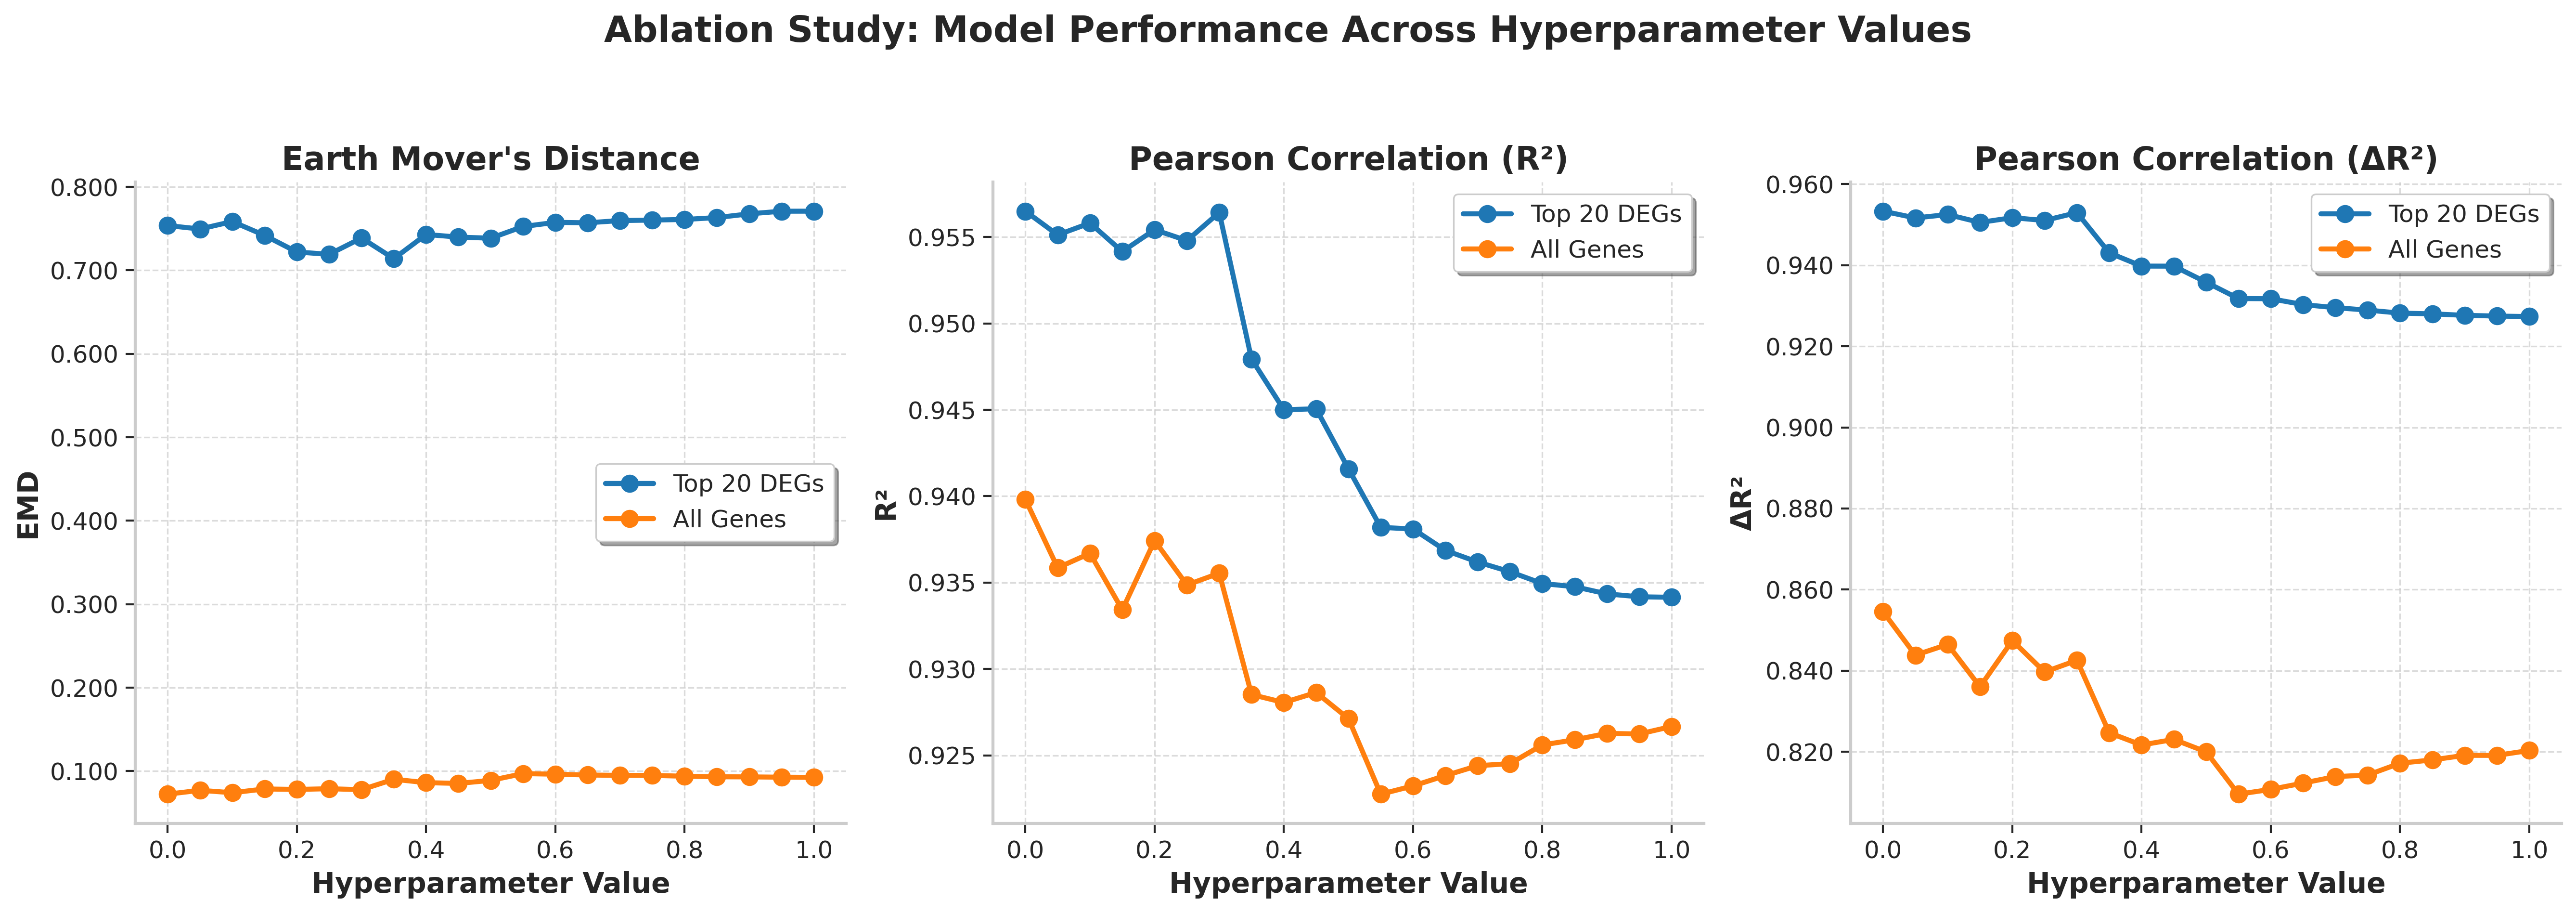

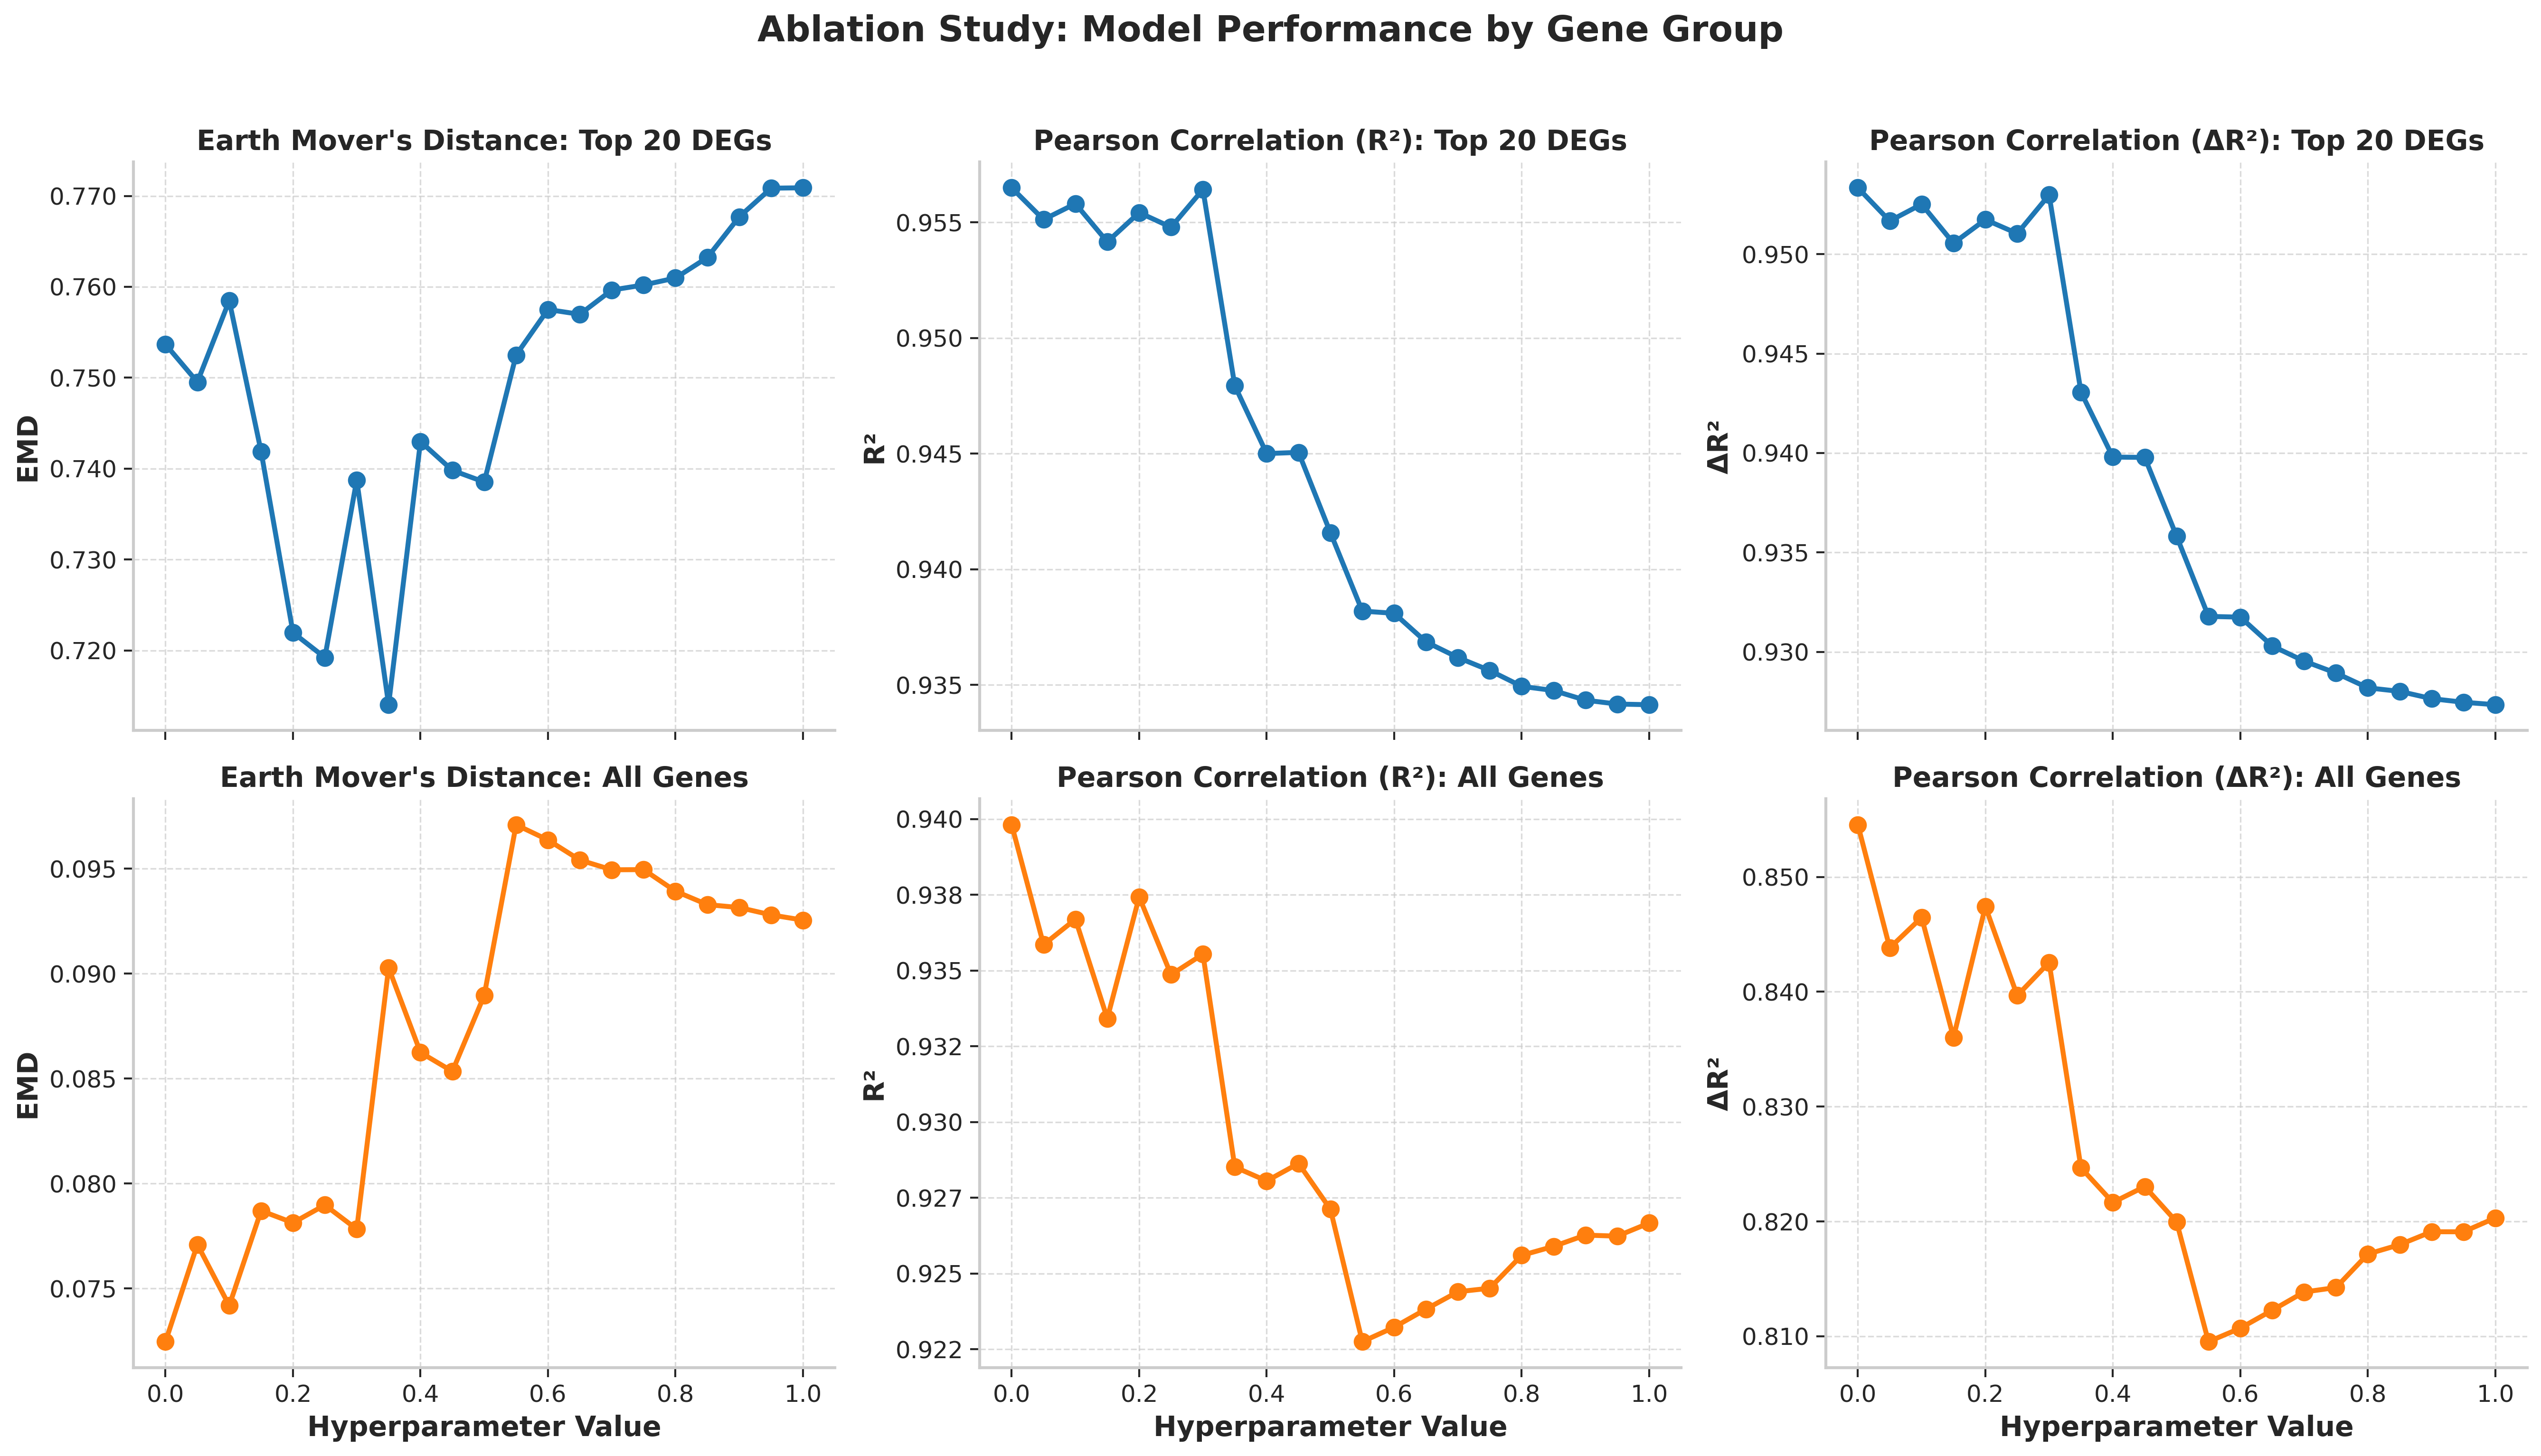

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# Assuming your dataframes are already created as emd_results, r2_results, and r2_results_subtract
# Let's create a function to extract the hyperparameter values and restructure the data

def prepare_data_for_plotting(df, metric_name):
    # Get hyperparameter values (column names that are numeric)
    hyperparam_values = [col for col in df.columns if not col.endswith('_var')]
    
    # Create a new dataframe for plotting
    plot_data = []
    
    for group in df.index:
        for param in hyperparam_values:
            plot_data.append({
                'Group': 'Top 20 DEGs' if group == '20' else 'All Genes',
                'Hyperparameter': float(param),
                metric_name: df.loc[group, param]
            })
    
    return pd.DataFrame(plot_data)

# Set up the plot style for publication quality
plt.rcParams.update({
    # 'font.family': 'sans-serif',
    # 'font.sans-serif': ['Arial'],
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Create figure with 3 subplots (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define colors
colors = {'Top 20 DEGs': '#1f77b4', 'All Genes': '#ff7f0e'}

# Prepare and plot each metric
metrics = {
    'EMD': emd_results,
    'R²': r2_results,
    'ΔR²': r2_results_subtract
}

metric_labels = {
    'EMD': 'Earth Mover\'s Distance',
    'R²': 'Pearson Correlation (R²)',
    'ΔR²': 'Pearson Correlation (ΔR²)'
}

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Create separate plots for each group to handle different scales
    for group in ['Top 20 DEGs', 'All Genes']:
        group_data = plot_data[plot_data['Group'] == group]
        
        # Plot the line
        axes[i].plot(
            group_data['Hyperparameter'], 
            group_data[metric_name], 
            'o-', 
            color=colors[group],
            linewidth=2.5,
            markersize=8,
            label=group
        )
    
    # Set titles and labels
    axes[i].set_title(metric_labels[metric_name], fontweight='bold', fontsize=16)
    axes[i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes[i].set_ylabel(metric_name, fontweight='bold')
    
    # Format y-axis to show more decimals
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Add grid for better readability
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    axes[i].legend(frameon=True, fancybox=True, shadow=True)
    
    # Use tight layout for better spacing
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Add a common title
plt.suptitle('Ablation Study: Model Performance Across Hyperparameter Values', 
             fontsize=18, fontweight='bold', y=1.05)

# Create a secondary plot for better visualization with different y-scales
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Plot Top 20 DEGs on top row
    top_data = plot_data[plot_data['Group'] == 'Top 20 DEGs']
    axes2[0, i].plot(
        top_data['Hyperparameter'], 
        top_data[metric_name], 
        'o-', 
        color=colors['Top 20 DEGs'],
        linewidth=2.5,
        markersize=8
    )
    axes2[0, i].set_title(f'{metric_labels[metric_name]}: Top 20 DEGs', fontweight='bold', fontsize=14)
    axes2[0, i].set_ylabel(metric_name, fontweight='bold')
    axes2[0, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[0, i].grid(True, linestyle='--', alpha=0.7)
    axes2[0, i].spines['top'].set_visible(False)
    axes2[0, i].spines['right'].set_visible(False)
    
    # Plot All Genes on bottom row
    all_data = plot_data[plot_data['Group'] == 'All Genes']
    axes2[1, i].plot(
        all_data['Hyperparameter'], 
        all_data[metric_name], 
        'o-', 
        color=colors['All Genes'],
        linewidth=2.5,
        markersize=8
    )
    axes2[1, i].set_title(f'{metric_labels[metric_name]}: All Genes', fontweight='bold', fontsize=14)
    axes2[1, i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes2[1, i].set_ylabel(metric_name, fontweight='bold')
    axes2[1, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[1, i].grid(True, linestyle='--', alpha=0.7)
    axes2[1, i].spines['top'].set_visible(False)
    axes2[1, i].spines['right'].set_visible(False)

plt.suptitle('Ablation Study: Model Performance by Gene Group', 
             fontsize=18, fontweight='bold', y=1.02)

# Adjust layout
fig.tight_layout()
fig2.tight_layout()

# Save the figures
fig.savefig('ablation_study_metrics_combined.png', bbox_inches='tight', dpi=300)
fig2.savefig('ablation_study_metrics_separate.png', bbox_inches='tight', dpi=300)

# Display the figures
plt.show()

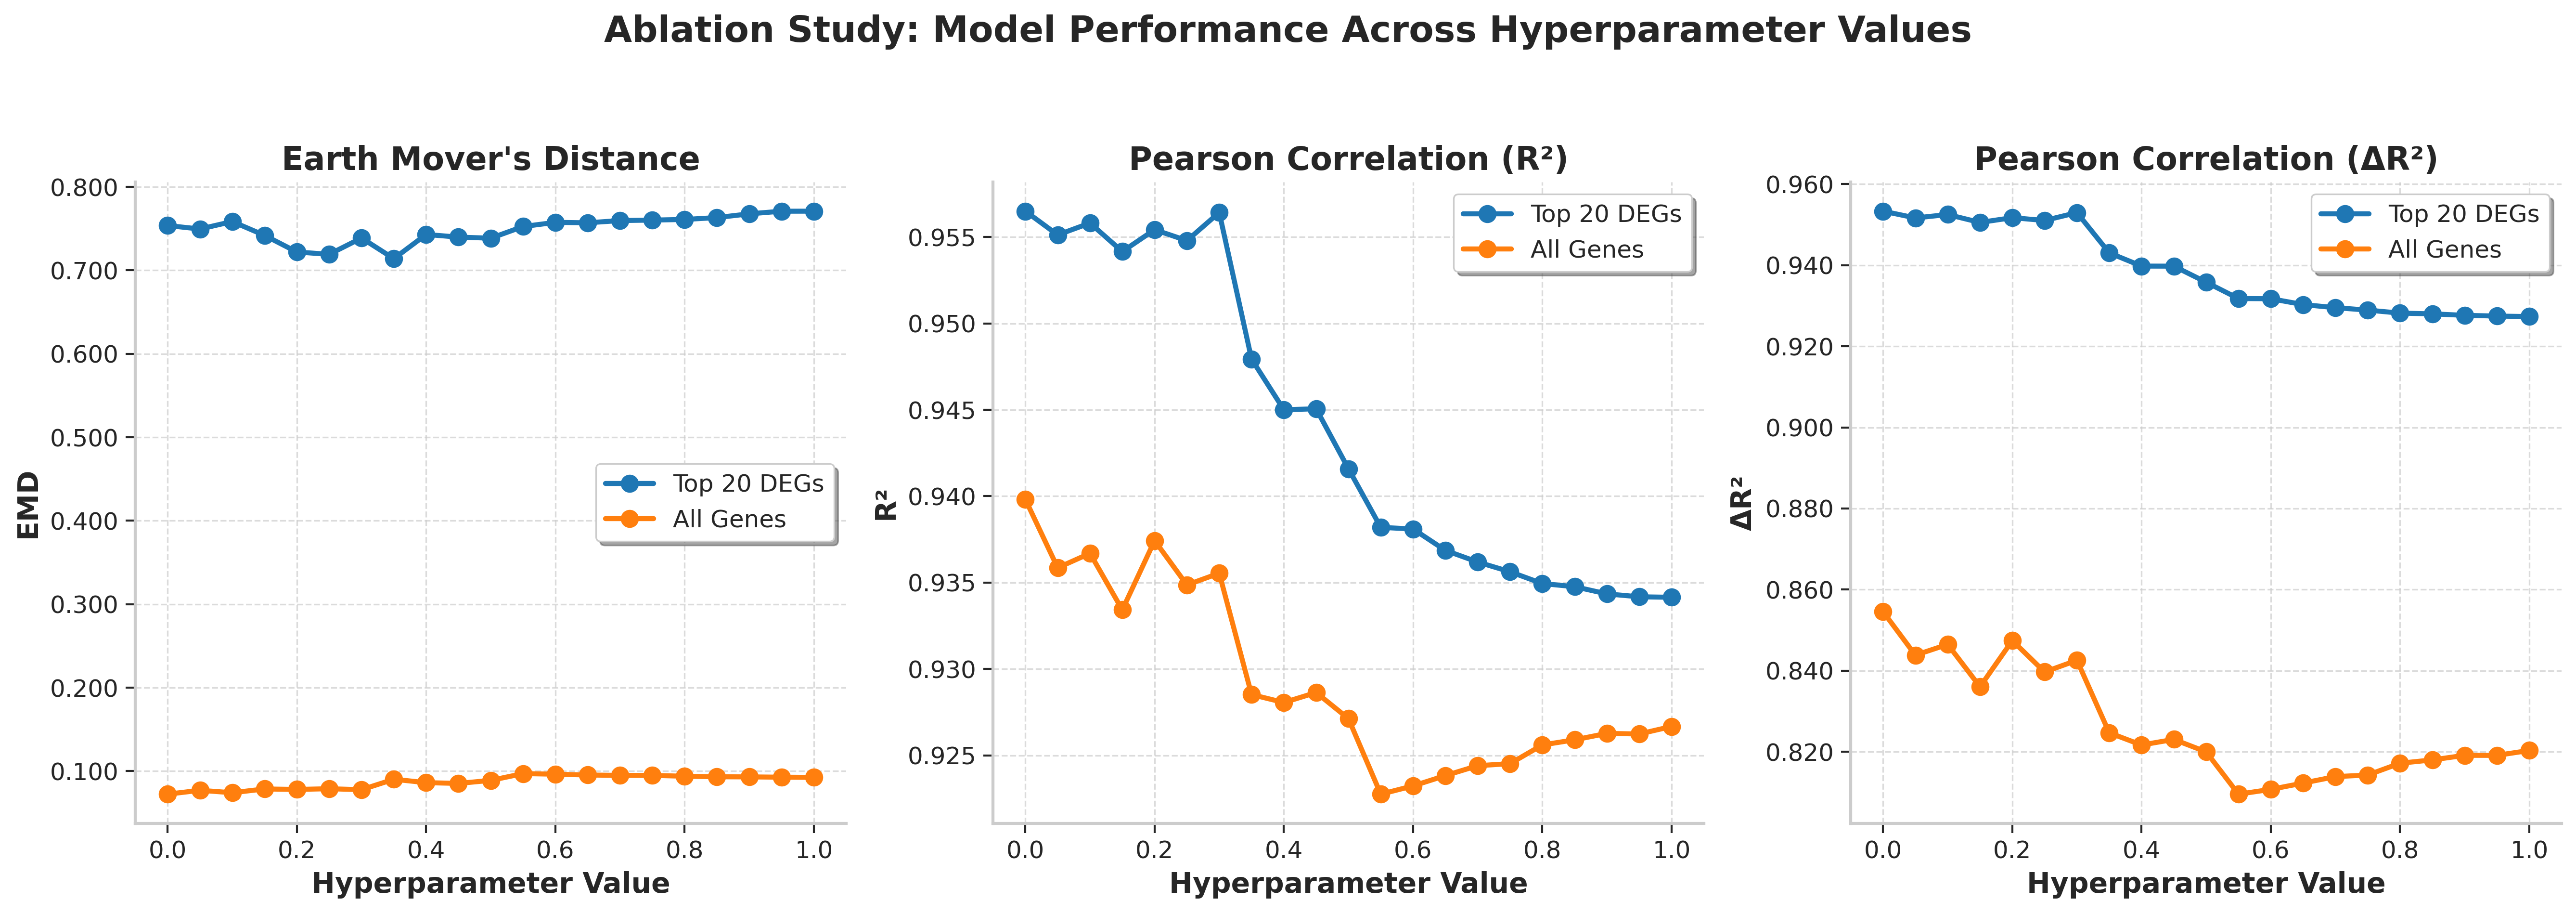

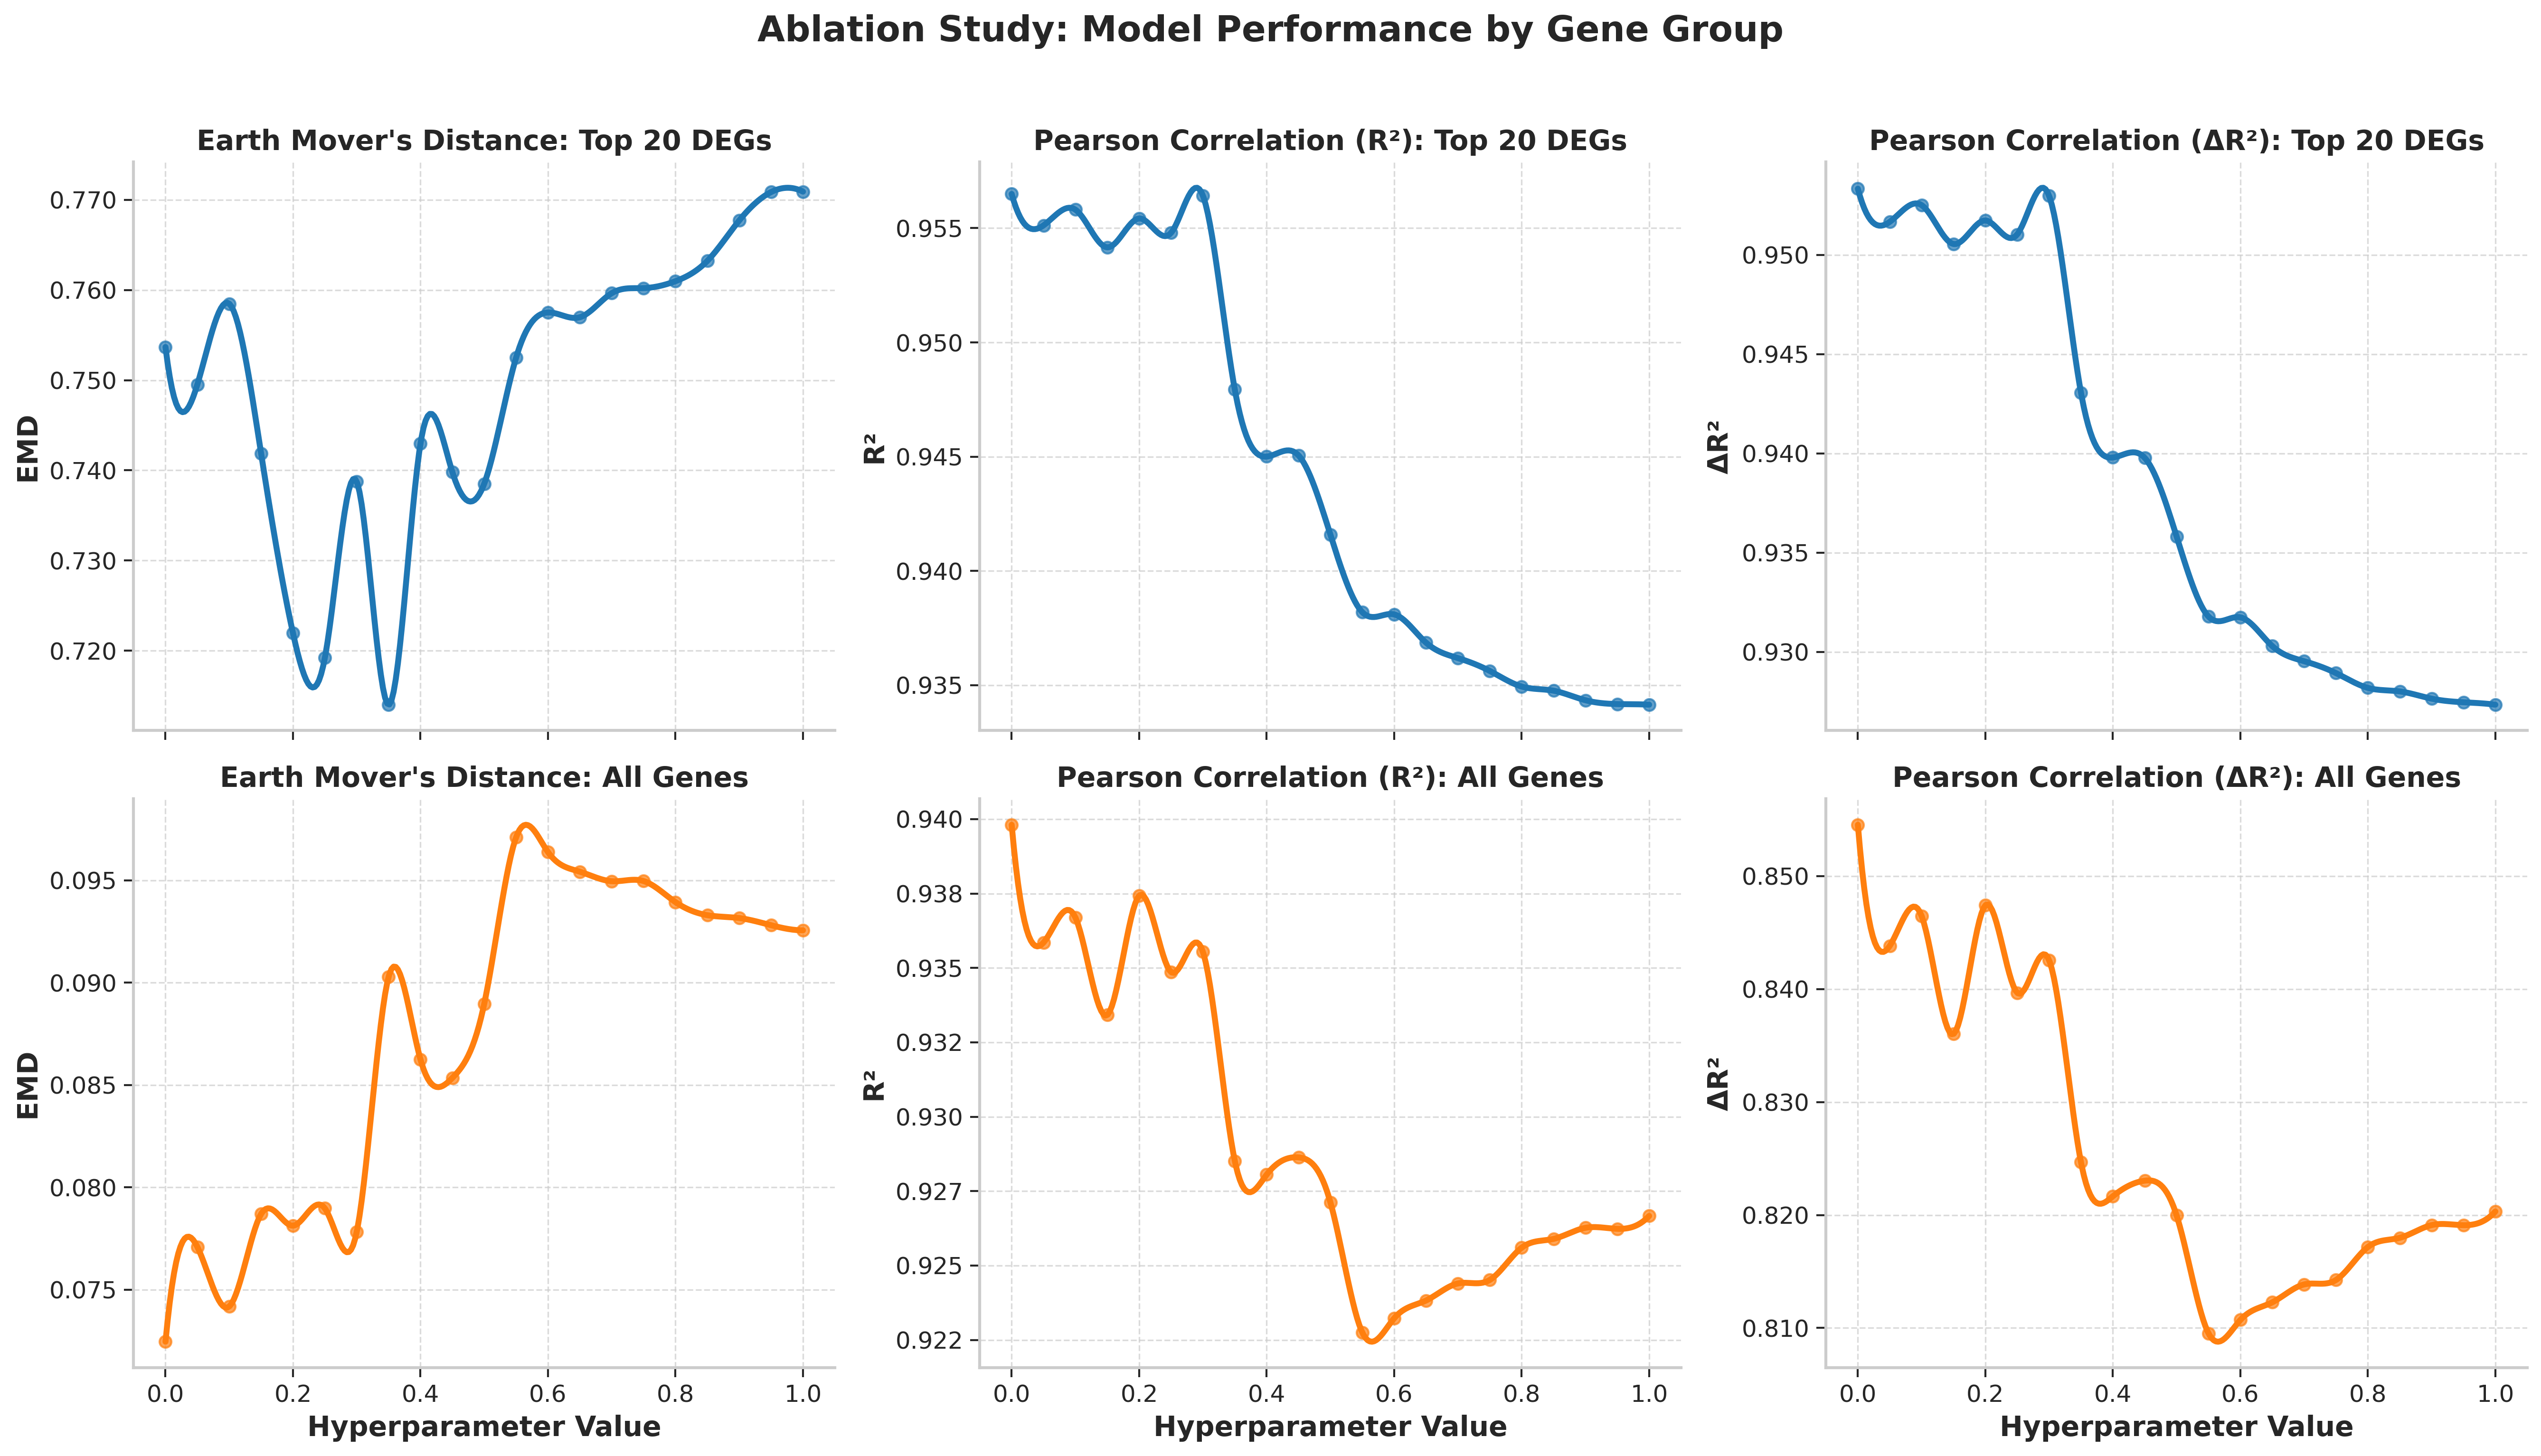

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import make_interp_spline

# Assuming your dataframes are already created as emd_results, r2_results, and r2_results_subtract
# Let's create a function to extract the hyperparameter values and restructure the data

def prepare_data_for_plotting(df, metric_name):
    # Get hyperparameter values (column names that are numeric)
    hyperparam_values = [col for col in df.columns if not col.endswith('_var')]
    
    # Create a new dataframe for plotting
    plot_data = []
    
    for group in df.index:
        for param in hyperparam_values:
            plot_data.append({
                'Group': 'Top 20 DEGs' if group == '20' else 'All Genes',
                'Hyperparameter': float(param),
                metric_name: df.loc[group, param]
            })
    
    return pd.DataFrame(plot_data)

# Set up the plot style for publication quality
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Create figure with 3 subplots (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define colors
colors = {'Top 20 DEGs': '#1f77b4', 'All Genes': '#ff7f0e'}

# Prepare and plot each metric
metrics = {
    'EMD': emd_results,
    'R²': r2_results,
    'ΔR²': r2_results_subtract
}

metric_labels = {
    'EMD': 'Earth Mover\'s Distance',
    'R²': 'Pearson Correlation (R²)',
    'ΔR²': 'Pearson Correlation (ΔR²)'
}

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Create separate plots for each group to handle different scales
    for group in ['Top 20 DEGs', 'All Genes']:
        group_data = plot_data[plot_data['Group'] == group]
        
        # Plot the line
        axes[i].plot(
            group_data['Hyperparameter'], 
            group_data[metric_name], 
            'o-', 
            color=colors[group],
            linewidth=2.5,
            markersize=8,
            label=group
        )
    
    # Set titles and labels
    axes[i].set_title(metric_labels[metric_name], fontweight='bold', fontsize=16)
    axes[i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes[i].set_ylabel(metric_name, fontweight='bold')
    
    # Format y-axis to show more decimals
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Add grid for better readability
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    axes[i].legend(frameon=True, fancybox=True, shadow=True)
    
    # Use tight layout for better spacing
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Add a common title
plt.suptitle('Ablation Study: Model Performance Across Hyperparameter Values', 
             fontsize=18, fontweight='bold', y=1.05)

# Function to create smooth curve
def smooth_curve(x, y, smoothness=300):
    x_new = np.linspace(min(x), max(x), smoothness)
    spl = make_interp_spline(x, y, k=3)  # Use cubic spline (k=3)
    y_smooth = spl(x_new)
    return x_new, y_smooth

# Create a secondary plot with smoothed lines for better visualization with different y-scales
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Plot Top 20 DEGs on top row
    top_data = plot_data[plot_data['Group'] == 'Top 20 DEGs']
    x = top_data['Hyperparameter'].values
    y = top_data[metric_name].values
    
    # Sort data by hyperparameter value to ensure proper smoothing
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[0, i].plot(x_smooth, y_smooth, '-', color=colors['Top 20 DEGs'], linewidth=3)
    axes2[0, i].plot(x, y, 'o', color=colors['Top 20 DEGs'], markersize=6, alpha=0.7)
    
    axes2[0, i].set_title(f'{metric_labels[metric_name]}: Top 20 DEGs', fontweight='bold', fontsize=14)
    axes2[0, i].set_ylabel(metric_name, fontweight='bold')
    axes2[0, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[0, i].grid(True, linestyle='--', alpha=0.7)
    axes2[0, i].spines['top'].set_visible(False)
    axes2[0, i].spines['right'].set_visible(False)
    
    # Plot All Genes on bottom row
    all_data = plot_data[plot_data['Group'] == 'All Genes']
    x = all_data['Hyperparameter'].values
    y = all_data[metric_name].values
    
    # Sort data by hyperparameter value
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[1, i].plot(x_smooth, y_smooth, '-', color=colors['All Genes'], linewidth=3)
    axes2[1, i].plot(x, y, 'o', color=colors['All Genes'], markersize=6, alpha=0.7)
    
    axes2[1, i].set_title(f'{metric_labels[metric_name]}: All Genes', fontweight='bold', fontsize=14)
    axes2[1, i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes2[1, i].set_ylabel(metric_name, fontweight='bold')
    axes2[1, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[1, i].grid(True, linestyle='--', alpha=0.7)
    axes2[1, i].spines['top'].set_visible(False)
    axes2[1, i].spines['right'].set_visible(False)

plt.suptitle('Ablation Study: Model Performance by Gene Group', 
             fontsize=18, fontweight='bold', y=1.02)

# Adjust layout
fig.tight_layout()
fig2.tight_layout()

# Save the figures
fig.savefig('ablation_study_metrics_combined.png', bbox_inches='tight', dpi=300)
fig2.savefig('ablation_study_metrics_separate_smoothed.png', bbox_inches='tight', dpi=300)

# Display the figures
plt.show()